# Corpus Nummorum (CN) Data Challange

---

**Goethe University Frankfurt am Main**

Summer Semester 2023

<br>

## *Multimodal Fusion Model for  historical coin classification*

---

**Authors:** Bastian Rothenburger, Garegin Ktoian 
<br>

**Contact:** Bastian Rothenburger ([s7072002@rz.uni-frankfurt.de](mailto:s7072002@rz.uni-frankfurt.de))<br>

---

<br>

## Table of Contents

---

- [1 Dataset Preparation](#1-Dataset-Preparation)
  - [1.1 Copy data to working directory](#1.1-Copy-data-to-working-directory)
  - [1.2 Drop classes below training threshold and merge back and frontside](#1.2-Drop-classes-below-training-threshold-and-merge-back-and-frontside)
  - [1.3 Apply train test split](#1.3-Apply-train-test-split)
  - [1.4 Add original coin descriptions](#1.4-Add-original-coin-descriptions)
- [2 Generation and embedding of alternative descriptions](#2-Generation-and-embedding-of-alternative-descriptions)
  - [2.1 Unique descriptions](#2.1-Unique-descriptions)
  - [2.2 Alternative descriptions](#2.2-Alternative-descriptions)
  - [2.3 Embbeding](#2.3-Embbeding)
- [3 Training](#3-Training)
  - [3.1 Setting training variables](#3.1-Setting-training-variables)
  - [3.2 ImageEncoder Training](#3.2-ImageEncoder-Training)
  - [3.3 TextEncoder Training](#3.3-TextEncoder-Training)
  - [3.4 Fusion Model Training](#3.4-Fusion-Model-Training)
- [4 Summary](#4-Summary)

<br>

## Setup

---

In [1]:

from ModelTrainer import ModelTrainer
import torchvision
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, resnet101, ResNet101_Weights 
from torchvision.models import swin_v2_b ,Swin_V2_B_Weights
import torchvision.models as models
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from DataPrep import copy_data_folder, create_csv_dataset, drop_empty_classes, merge_images, add_class_index, split_dataset, val_train_csv, add_type_description_to_csv, sanity_check
from ChatGptHelper import extract_unique_labels, generate_alternative_descriptions, generate_embeddings
from Architectures import TextClassefier, Transformer_TextClassifier, Fusion, Fusion_From_Scratch
# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
%load_ext autoreload
%autoreload 2

cuda:0


In [2]:
#specify path to root folder

dir = r"F:\Users\basti\Documents\Goethe Uni\Data Challange\Multimodal - Types"

# 1 Dataset Preparation

---

### 1.1 Copy data to working directory

In [3]:
Path_to_coin_dataset = r"F:\Users\basti\Documents\Goethe Uni\Data Challange\CN_dataset_04_23\dataset_coins - Original"
destination_path = dir+ "\\data\\dataset_coins"

if not os.path.exists(destination_path):
    copy_data_folder(Path_to_coin_dataset, dir+ "\\data\\dataset_coins" )

### 1.2 Drop classes below training threshold and merge back and frontside

In [4]:
#data prep
# Create the dataset CSV file
IMAGE_DIR = dir + "\\data\\dataset_coins"
CSV_FILE = "allcoins.csv"

create_csv_dataset(IMAGE_DIR, CSV_FILE)

#clean classes with not enough samples
#specify threshold
thresh = 20
drop_empty_classes(IMAGE_DIR, CSV_FILE, thresh)
CSV_FILE2 = "trainablecoins.csv"
create_csv_dataset(IMAGE_DIR, CSV_FILE2)

#merge front and backside and add black bars at the top and bottom
merge_images(CSV_FILE2, dir+'\\data\\merged_coins')
CSV_FILE3 = "mergedcoins.csv"
IMAGE_DIR = dir + "\\data\\merged_coins"
create_csv_dataset(IMAGE_DIR, CSV_FILE3)

# we add a class index in order to make the labels trainable
# the reverse mapping is saved at class_index_map.pkl as a python dict this can be used to translate
# the prediction of the model to the real coin
add_class_index(CSV_FILE3)

### 1.3 Apply train test split

In [48]:
# only run this one time
# this allows for adding augmentations just to the training and not to the validation set

Already_splitted = True
if not Already_splitted:
    dataset_path = dir + "\\data\\merged_coins"
    train_path = dir + "\\data\\train"
    validation_path = dir + "\\data\\val"
    validation_percentage = 0.25 
    seed = 123
    split_dataset(dataset_path, train_path, validation_path, validation_percentage, seed)
    
val_train_csv('mergedcoins.csv', train_path, dir, 'train.csv')
val_train_csv('mergedcoins.csv', validation_path, dir, 'val.csv')

### 1.4 Add original coin descriptions

In [50]:
add_type_description_to_csv('train.csv', 'CN_coin_descriptions.csv', 'train.csv')
add_type_description_to_csv('val.csv', 'CN_coin_descriptions.csv', 'val.csv')

#Sanity check
sanity_check('train.csv', 'val.csv', thresh)

f:\Users\basti\Documents\Goethe Uni\Data Challange\multimodal - Types\DataPrep.py:223: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2[['id', 'description']] = df2['combined'].str.split(',', 1, expand=True)
f:\Users\basti\Documents\Goethe Uni\Data Challange\multimodal - Types\DataPrep.py:223: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2[['id', 'description']] = df2['combined'].str.split(',', 1, expand=True)


# 2 Generation and embedding of alternative descriptions

---

### 2.1 Unique descriptions

In [52]:
# doing this for just the training set is sufficient as classes match
#reason for this are the api costs
extract_unique_labels('train.csv', 'unique_labels.csv')

### 2.2 Alternative descriptions

In [53]:
"""
You need an API key to run this
We used GPT4 
Standard open AI accounts will only have access to weaker models (as of the the time of the experiment)
We recommend using text-davinci-003 in this case
In order to specify the model go to ChatGptHelper and change it in get_alternative_description
Takes roughly 50 min for 95 classes
Also you have to clean the resulting file manually we are not sure what causes the issues
All descriptions should be there but some will extend to the second column
"""

API_key = 'Your API key'

if not os.path.exists(dir + "\\alternative_descriptions_train.csv"):
    generate_alternative_descriptions(API_key, 'unique_labels.csv', 'alternative_descriptions_train.csv')
if not os.path.exists(dir + "\\alternative_descriptions_val.csv"):
    generate_alternative_descriptions(API_key,'unique_labels.csv', 'alternative_descriptions_val.csv')


### 2.3 Embbeding

In [32]:
"""
disclaimer the output for alternative descriptions is to cmplicated to be split by csv_read or i am simply to stupid
if you use excels text to columns function with delimeter , and save
you can use csv_read with delimeter ; afterwards and it works just fine

"""

API_key = 'Your API key'

if not os.path.exists(dir + "\\embeddings_train_alternative.npy"):
    generate_embeddings(API_key, 'alternative_descriptions_train.csv', 'text-embedding-ada-002', 'embeddings_train_alternative.npy')
if not os.path.exists(dir + "\\embeddings_val_alternative.npy"):
    generate_embeddings(API_key, 'alternative_descriptions_val.csv', 'text-embedding-ada-002', 'embeddings_val_alternative.npy')

print(np.load('embeddings_val_alternative.npy').shape)
print(np.load('embeddings_train_alternative.npy').shape)

Total embeding processes with  0 problems
Total embeding processes with  0 problems
(95, 10, 1536)
(95, 10, 1536)


# 3 Training

---

<br>

## 3.1 Setting training variables

---

In [3]:

dir = r"F:\Users\basti\Documents\Goethe Uni\Data Challange\multimodal - Types"
model_save_path = dir +"\\models"

# specifies image data 
train, val = dir+"\\train.csv", dir+"\\val.csv"

# specifies language data
train_emb, val_emb   = 'embeddings_train_alternative.npy', 'embeddings_val_alternative.npy'

# specifies output feature size for imageencoder, textencoder and fusionmodel 
output_features = len(pd.read_csv(train, delimiter=',', skiprows=0, low_memory=False, encoding='iso-8859-1')["class"].unique())


"""
set to true if you want to apply augments
should increase performance slightly (roughly 2-3%)
but also increases training time
"""
use_augments = False

if use_augments:
    train_augmentations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((299, 299))
    ])
else:
    train_augmentations = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((299, 299))
    ])

## 3.2 ImageEncoder Training

---

In [5]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, output_features)

# hyperparameters can be set here. Check ModelTrainer.py for details. If not specified differently default values of the Modeltrainer have been used 
Solver = ModelTrainer(model=model,  
            train_path=train,
            train_embedding_path=train_emb, 
            val_path=val,
            val_embedding_path=val_emb, 
            train_augmentations=train_augmentations,
            save_path=model_save_path,
            postfix='ImageEncoder_ResNet18',
            batch_size=16
            )

cuda
2445
torch.Size([16, 3, 299, 299]) torch.Size([16, 95]) torch.Size([16, 1536])
data loaded


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train Loss: 3.4033 Acc: 0.2131
val Loss: 2.5531 Acc: 0.3639
Epoch 2/10
----------
train Loss: 2.1174 Acc: 0.4969
val Loss: 1.7389 Acc: 0.5600
Epoch 3/10
----------
train Loss: 1.3051 Acc: 0.7268
val Loss: 1.2744 Acc: 0.6787
Epoch 4/10
----------
train Loss: 0.7399 Acc: 0.8806
val Loss: 1.1502 Acc: 0.7110
Epoch 5/10
----------
train Loss: 0.3486 Acc: 0.9693
val Loss: 0.8912 Acc: 0.7897
Epoch 6/10
----------
train Loss: 0.2207 Acc: 0.9910
val Loss: 0.8383 Acc: 0.7935
Epoch 7/10
----------
train Loss: 0.1518 Acc: 0.9971
val Loss: 0.8021 Acc: 0.8000
Epoch 8/10
----------
train Loss: 0.1033 Acc: 0.9988
val Loss: 0.7903 Acc: 0.8090
Epoch 9/10
----------
train Loss: 0.0766 Acc: 0.9992
val Loss: 0.7700 Acc: 0.8077
Epoch 10/10
----------
train Loss: 0.0652 Acc: 0.9996
val Loss: 0.7663 Acc: 0.8103


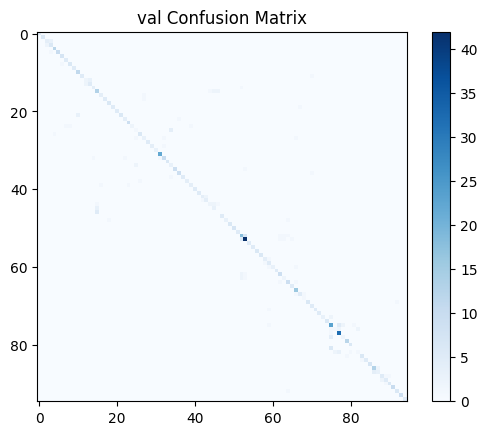


Best val Acc: 0.810323


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:

Solver.train()

## 3.3 TextEncoder Training

---

In [4]:

model = TextClassefier(input_size=1536, hidden_size=10000, output_size=output_features)

# hyperparameters can be set here. Check ModelTrainer.py for details. If not specified differently default values of the Modeltrainer have been used 
Solver = ModelTrainer(model=model,  
            train_path=train, 
           train_embedding_path=train_emb, 
            val_path=val,
            val_embedding_path=val_emb, 
            train_augmentations=train_augmentations,
            save_path=model_save_path,
            postfix='TextEncoder',
            batch_size=4
            )

cuda
2445
torch.Size([4, 3, 299, 299]) torch.Size([4, 95]) torch.Size([4, 1536])
data loaded


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train Loss: 3.5875 Acc: 0.1824
val Loss: 2.3568 Acc: 0.3794
Epoch 2/10
----------
train Loss: 1.5332 Acc: 0.5464
val Loss: 0.9590 Acc: 0.6671
Epoch 3/10
----------
train Loss: 0.7759 Acc: 0.7297
val Loss: 0.6843 Acc: 0.7613
Epoch 4/10
----------
train Loss: 0.5583 Acc: 0.8000
val Loss: 0.5712 Acc: 0.7923
Epoch 5/10
----------
train Loss: 0.3911 Acc: 0.8360
val Loss: 0.4960 Acc: 0.8039
Epoch 6/10
----------
train Loss: 0.3414 Acc: 0.8503
val Loss: 0.4921 Acc: 0.7742
Epoch 7/10
----------
train Loss: 0.2972 Acc: 0.8744
val Loss: 0.4491 Acc: 0.7884
Epoch 8/10
----------
train Loss: 0.2818 Acc: 0.8773
val Loss: 0.4102 Acc: 0.8077
Epoch 9/10
----------
train Loss: 0.2355 Acc: 0.8986
val Loss: 0.4608 Acc: 0.8206
Epoch 10/10
----------
train Loss: 0.2265 Acc: 0.9031
val Loss: 0.4793 Acc: 0.8103


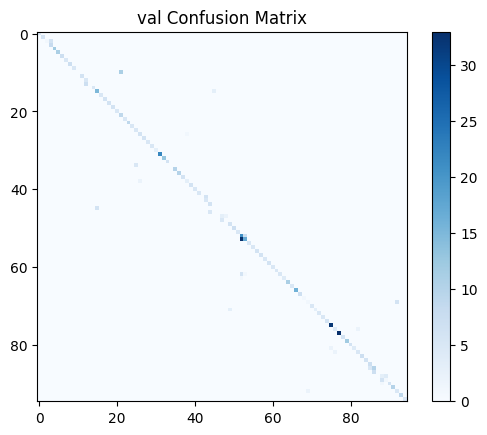


Best val Acc: 0.820645


TextClassefier(
  (fc1): Linear(in_features=1536, out_features=10000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10000, out_features=10000, bias=True)
  (fc3): Linear(in_features=10000, out_features=95, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [5]:
Solver.train(mulitmodal=True)

## 3.4 Fusion Model Training

---

In [6]:
TextModel = TextClassefier(input_size=1536, hidden_size=10000, output_size=output_features)
image_encoder = dir + "\\models\modelImageEncoder_ResNet18.tar"
text_encoder = dir + "\\models\modelTextEncoder.tar"
model = Fusion(image_encoder, text_encoder, TextModel, output_size=output_features)

# hyperparameters can be set here. Check ModelTrainer.py for details. If not specified differently default values of the Modeltrainer have been used 
Solver = ModelTrainer(model=model,  
            train_path=train, 
           train_embedding_path=train_emb, 
            val_path=val,
            val_embedding_path=val_emb, 
            train_augmentations=train_augmentations,
            save_path=model_save_path,
            postfix='TR0_Res18_types_with_des_78_multimodal',
            batch_size=4,
            )

cuda
2445
torch.Size([4, 3, 299, 299]) torch.Size([4, 95]) torch.Size([4, 1536])
data loaded


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train Loss: 0.1637 Acc: 0.9337
val Loss: 0.4893 Acc: 0.8323
Epoch 2/10
----------
train Loss: 0.1665 Acc: 0.9297
val Loss: 0.4211 Acc: 0.8516
Epoch 3/10
----------
train Loss: 0.1389 Acc: 0.9374
val Loss: 0.4325 Acc: 0.8439
Epoch 4/10
----------
train Loss: 0.1332 Acc: 0.9476
val Loss: 0.4234 Acc: 0.8400
Epoch 5/10
----------
train Loss: 0.1289 Acc: 0.9476
val Loss: 0.4489 Acc: 0.8439
Epoch 6/10
----------
train Loss: 0.1235 Acc: 0.9493
val Loss: 0.4185 Acc: 0.8413
Epoch 7/10
----------
train Loss: 0.1187 Acc: 0.9566
val Loss: 0.4143 Acc: 0.8452
Epoch 8/10
----------
train Loss: 0.1205 Acc: 0.9513
val Loss: 0.4706 Acc: 0.8284
Epoch 9/10
----------
train Loss: 0.1129 Acc: 0.9562
val Loss: 0.3767 Acc: 0.8465
Epoch 10/10
----------
train Loss: 0.1168 Acc: 0.9550
val Loss: 0.4589 Acc: 0.8361


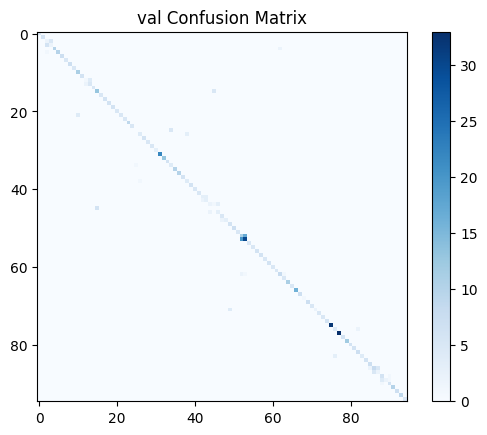


Best val Acc: 0.851613


Fusion(
  (visual_embedding_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [14]:
# multimodel = True allows for the embbeding to be processed by the model. Has to be false if conventinal imagemodels are supposed to be trained
Solver.train(mulitmodal=True)

# 4 Summary

---

In [6]:
print('Summary of results: \n')
checkpoint = torch.load(dir + "\\models\\statsImageEncoder_ResNet18.tar")
acc = []
for i in checkpoint['val_acc']:
    acc.append(i.item())
print('Best valdiation accuracy ImageEncoder:  ', max(acc)*100, '%')
checkpoint = torch.load(dir +"\\models\\statsTextEncoder.tar")
acc = []
for i in checkpoint['val_acc']:
    acc.append(i.item())
print('Best valdiation accuracy TextEncoder:  ', max(acc)*100, '%')
checkpoint = torch.load(dir +"\\models\\statsTR0_Res18_types_with_des_78_multimodal.tar")
acc = []
for i in checkpoint['val_acc']:
    acc.append(i.item())
print('Best valdiation accuracy FusionModel:  ', max(acc)*100, '%')

Summary of results: 

Best valdiation accuracy ImageEncoder:   81.03225806451613 %
Best valdiation accuracy TextEncoder:   82.06451612903226 %
Best valdiation accuracy FusionModel:   85.16129032258064 %
